# Adaptive bandwidth KDE

## Introduction

The classic kernel density estimator we have introduced in previous notebooks implies the standard deviation of each of the kernels is constant. Depending on the shape of $f$ and the method used to estimate the bandwidth $h$, the resulting estimator will be more likely to either undersmooth or oversmooth the true $f$.  

For example, if the true $f$ has tall peaks and/or multimodalities the Improved Sheather-Jones method will be surely able to capture them appropiately. However, it will introduce unnecesary noise in more stable regions of the density. On the other hand, if we use a more conservative method for these kind of densities, like the Silverman's rule of thumb, the estimate will not present wiggly regions, at the cost of an oversmoothed density.

While this problem also appears in unimodal and skewed distributions, it is not too harmful if the skewness is not extreme.

A useful extension is to use a different $h$ depending on the local density of the input data points. This concept is known as adaptive or variable KDE. In regions with higher density the bandwidth could be decreased, while in the sparser regions it could be stretched out. 

Two popular alternatives in the literature are the balloon and the sample point estimators. The first one suffers from a number of drawbacks, like not integrating to one over the entire domain. The second uses a different bandwidth for each data point $X_i$ and results in a true density. Both of these alternatives modify the calculation of the bandwidth but don't modify the weight assigned to each kernel.

A (completely) different alternative is a kernel density estimator that adapts both the bandwidth $h$ and the weight assigned to each kernel. With the concept that a Gaussian KDE is the simple average of $N$ Gaussian distributions with shared $\sigma$ in mind, we can easily think of a more flexible approach: a kernel density estimate based on a weighted average of $N$ Gaussian distributions with variable $\sigma$. In this notebook we are going to implement this via the Expectation-Maximization algorithm.

<center> 
    <strong>EXAMPLES SHOWING HOW UNDER-SMOOTH AND OVER-SMOOTH LOOK LIKE</strong>
</center>

## Sample point estimator

While the classic kernel density estimator uses a constant bandwidth $h$ for all the data points $X_i$, the sample point estimator uses a different bandwidth for each one. The estimate of $f$ at every $x$ is then an *average of differently scaled kernels* centered at each data point $X_i$. Thus, the estimator is defined as follows:

$$
\displaystyle \hat{f}_{SP}(x; h(X_i)) = \frac{1}{N}\sum_{i=1}^N{\frac{1}{h(X_i)}\kappa\left( \frac{x - X_i}{h(X_i)}\right)}
\tag{4.1}
$$

While we had a constant $h$ for all $X_i$, now we have a $h(X_i)$ that depends on the sample point. The following is one of the possible approaches to calculate the adjustment factor and consequently the sample point estimator.

1. Calculate $\hat{f}(x, h)$ as usual. The bandwidth can be estimated by any of the methods presented and we can call the resulting $\hat{f}$ a pilot estimate.
2. Determine the modification parameters $s_i$, $i = 1, \cdots, n$ as 
$$
s_i = \left(\frac{\hat{f}(X_i, h)}{T}\right) ^ {-c}
\tag{4.2}
$$

where $c \ge 0$ and $T$ is the geometric mean of the pilot density estimate at all the sample points, $\hat{f}(X_1, h)$, $\hat{f}(X_2, h)$, $\cdots$, $\hat{f}(X_N, h)$

$$
T = \exp{\left(\frac{1}{N} \sum_{i=1}^{N}{\ln{\hat{f}(X_i, h)}} \right)}
\tag{4.3}
$$

3. Finally, the sample point estimator is

$$
\hat{f}(x, h) = \frac{1}{Nh} \sum_{i=1}^{N}{\frac{1}{s_i}\kappa\left(\frac{x - X_i}{hs_i} \right)}
\tag{4.4}
$$

In the case that the Gaussian kernel is used, the sample point estimator results in 

$$
\hat{f}(x;h) = \frac{1}{N}\sum_{i=1}^N{\frac{1}{\sqrt{2\pi}hs_i}e^{-\frac{1}{2}\left(\frac{x - X_i}{hs_i}\right)^2}}
\tag{4.5}
$$

It is not difficult to see the resulting estimator is a simple average of Gaussian distributions centered at each data point with a standard deviation $hs_i$ specific to each data point.

**Remarks**

* If $c=0$ or $\hat{f}(X_i, h) = T$ then $s_i=1$ and the sample point estimator is equal to the usual constant bandwidth KDE.  
* If $\hat{f}(X_i, h)$ is smaller than the geometric mean of $\hat{f}(\cdot, h)$ then $s_i \gt 1$ and the kernel centered at $X_i$ is stretched out.
* In the opposite case, when $s_i \lt 1$ the kernel centered at $X_i$ is narrowed.

In practice the parameter $c$ can be initially set to 0.5. It can be seen as a parameter that controls how much to adjust the bandwidth. Larger values are related to more strong bandwidth modifications.

<!-- Question: Why do we use geometric mean? -->

In [2]:
import sys
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.rcParams['figure.figsize'] = [10, 7]
sys.path.append('../src/')
from my_functions import convolution_kde, h_isj, h_sil

# Colors
BLUE = "#3498db"
DARK_BLUE = "#2980b9"
NIGHT_BLUE = "#2c3e50"
DARK_RED = "#c0392b"
LIGHT_BLUE = "#56B4E9"
LIGHT_GRAY = "#474747"

In [3]:
def gaussian_kde_adap(x, h=None, grid_len=256, extend=True):
    """
    Straightforward implementation of a Sample Point adaptive KDE.
    
    Parameters
    ----------
    x : numpy array
        1 dimensional array of sample data from the variable for which a 
        density estimate is desired.
    h : float, optional
        Bandwidth (standard deviation of each Gaussian component)
        Defaults to None, which uses Gaussian robust rule of thumb.
    grid_len : int, optional
        Number of points where the kernel is evaluated. 
        Defaults to 256.
    extend: boolean, optional
        Whether to extend the domain of the observed data or not. 
        Defaults to True.

    Returns
    -------
    grid : Gridded numpy array for the x values.
    pdf : Numpy array for the density estimates.
    """
    
    x_len = len(x)
    
    if h is None:
        s = min(np.std(x), stats.iqr(x) / 1.34)
        h = 0.9 * s * x_len ** (-0.2)
    
    # Step 1: Calculate \hat{f} as usual.
    grid, pdf = convolution_kde(x=x, h=h, grid_len=grid_len, extend=extend)
    
    # Step 2: Determine the modification factors.
    # 2a: Geometric mean of KDE evaluated at sample points.
    pdf_interp = np.interp(x, grid, pdf)
    pdf_interp_geom_mean = np.exp(np.mean(np.log(pdf_interp))) # (1)
    
    # 2b: Compute modification factors.
    c = 0.5
    adj_factor = (pdf_interp_geom_mean / pdf_interp) ** c
    h_adjusted = h * adj_factor
    
    pdf_mat = np.exp(-0.5 * ((grid - x[:, None]) / h_adjusted[:, None]) ** 2) / ((2 * np.pi) ** 0.5 * h_adjusted[:, None])
    pdf = np.mean(pdf_mat, axis=0)

    return grid, pdf, h_adjusted

# (1) scipy.gmean is an alternative for the calculation. 
# However, the time speedup is within 5%.
# And it takes 2.8e-4 secs for 100k array. 
# Then, there's not significal speedup.

## Toy example

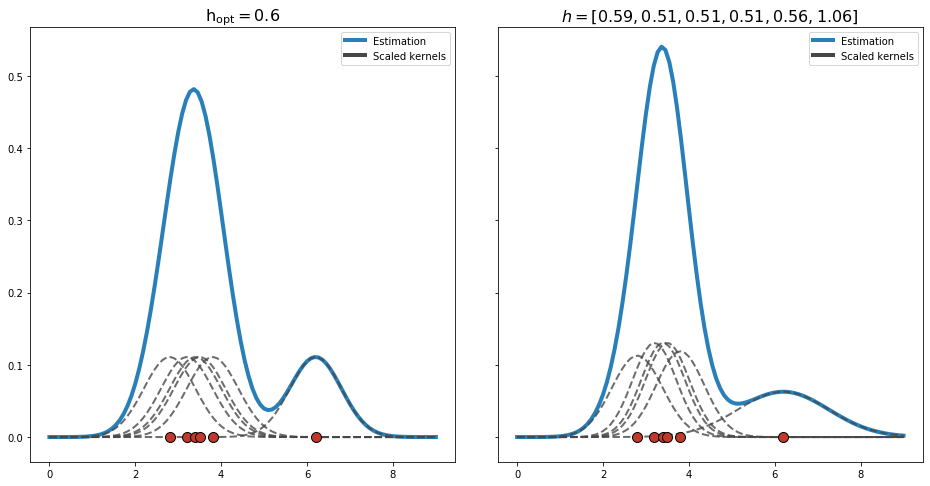

In [4]:
# Helper function to be used in title
def convert(list): 
    # Converting integer list to string list 
    s = [str(i) for i in list] 
    # Join list items using join() 
    res = ", ".join(s)
    return res 

# Data
rvs = np.array([2.8, 3.2, 3.4, 3.5, 3.8, 6.2])
h_opt =  0.6
h_ada = np.array([0.59, 0.51, 0.51, 0.51, 0.56, 1.06])
x_grid = np.linspace(0, 9, 100)

# "Optimal" bandwidth
kernels_opt = np.transpose([stats.norm.pdf(x_grid, m, h_opt) for m in rvs]) / len(rvs)
pdf_opt = np.sum(kernels_opt, axis=1)

# Adaptative bandwidth
kernels_ada = np.transpose([stats.norm.pdf(x_grid, m, s) for m, s in zip(rvs, h_ada)]) / len(rvs)
pdf_ada = np.sum(kernels_ada, axis=1)

# Plot
colors = [DARK_BLUE, LIGHT_GRAY]
lines = [Line2D([0], [0], color=c, linewidth=4) for c in colors]
labels = ["Estimation", "Scaled kernels"]

fig, axes = plt.subplots(1, 2, figsize = (16, 8), sharey=True)

axes[0].plot(x_grid, pdf_opt, linewidth=4, color=DARK_BLUE, zorder=1)
axes[0].plot(x_grid, kernels_opt, linewidth = 2, linestyle="--", color=LIGHT_GRAY, alpha=0.8, zorder=2)
axes[0].scatter(rvs, np.zeros(len(rvs)), s=100, color=DARK_RED, edgecolor='black', zorder=3)
axes[0].set_title(r"$\mathrm{h_{opt}} = 0.6$", size=16)
axes[0].legend(lines, labels);

axes[1].plot(x_grid, pdf_ada, linewidth=4, color=DARK_BLUE, zorder=1)
axes[1].plot(x_grid, kernels_ada, linewidth = 2, linestyle="--", color=LIGHT_GRAY, alpha=0.8, zorder=2)
axes[1].scatter(rvs, np.zeros(len(rvs)), s=100, color=DARK_RED, edgecolor='black', zorder=3)
axes[1].set_title(r"$ h = [{vals}]$".format(vals=convert(h_ada)), size=16)
axes[1].legend(lines, labels)

plt.subplots_adjust(wspace=0.1)

In [5]:
# Helper functions to be used
def generate_rvs(n, mean, sd, wt):
    assert len(mean) == len(sd) == len(wt)
    assert np.sum(wt) == 1
    x = np.concatenate((
        list(map(lambda m, s, w: stats.norm.rvs(m, s, int(np.round(n * w))), mean, sd, wt))
    ))
    return x

def get_pdf(x_grid, mean, sd, wt):
    assert len(mean) == len(sd) == len(wt)
    assert np.sum(wt) == 1
    pdf = np.average(list((map(lambda m, s: stats.norm.pdf(x_grid, m, s), mean, sd))), axis=0, weights=wt)
    return pdf

def plot_custom_kde(x_grid, pdf_true, x1, y1, x2, y2):
    
    fig, axes = plt.subplots(1, 2, figsize = (16, 8), sharey=True)

    axes[0].plot(x_grid, pdf_true, color="black", linewidth=4, linestyle="--", label="True")
    axes[0].plot(x1, y1, color=DARK_BLUE, linewidth=4, label="Estimation")
    axes[0].scatter(rvs, np.zeros(n), s=100, color=DARK_RED, edgecolor='black', alpha=0.6)
    axes[0].set_title("Constant bandwidth estimator", size=16)
    axes[0].legend();

    axes[1].plot(x_grid, pdf_true, color="black", linewidth=4, linestyle="--", label="True")
    axes[1].plot(x2, y2, color=DARK_BLUE, linewidth=4, label="Estimation")
    axes[1].scatter(rvs, np.zeros(n), s=100, color=DARK_RED, edgecolor='black', alpha=0.6)
    axes[1].set_title("Sample point estimator", size=16)
    axes[1].legend();
    
    plt.subplots_adjust(wspace=0.1)

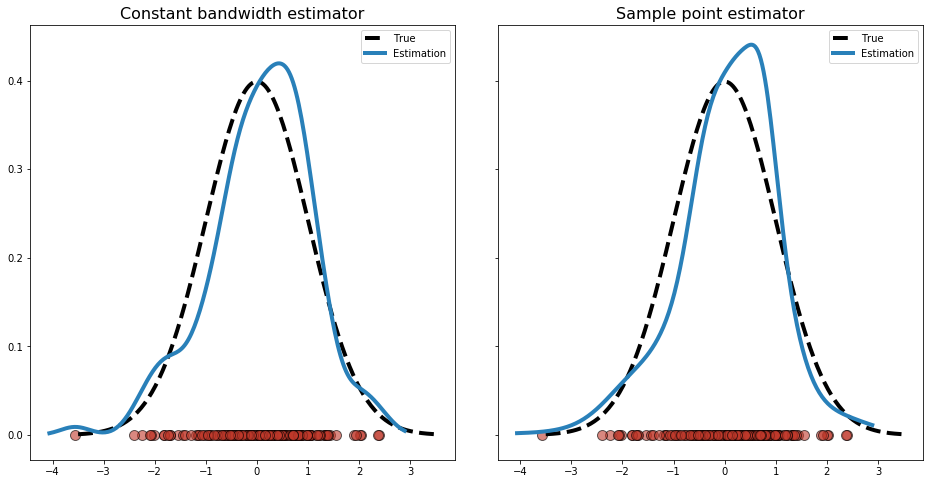

In [6]:
np.random.seed(1234)
n = 150
x_grid = np.linspace(-3.5, 3.5, num=200)

rvs = generate_rvs(n, [0], [1], [1])
pdf_true = get_pdf(x_grid, [0], [1], [1])

x1, y1 = convolution_kde(rvs)
x2, y2, h = gaussian_kde_adap(rvs)

plot_custom_kde(x_grid, pdf_true, x1, y1, x2, y2)

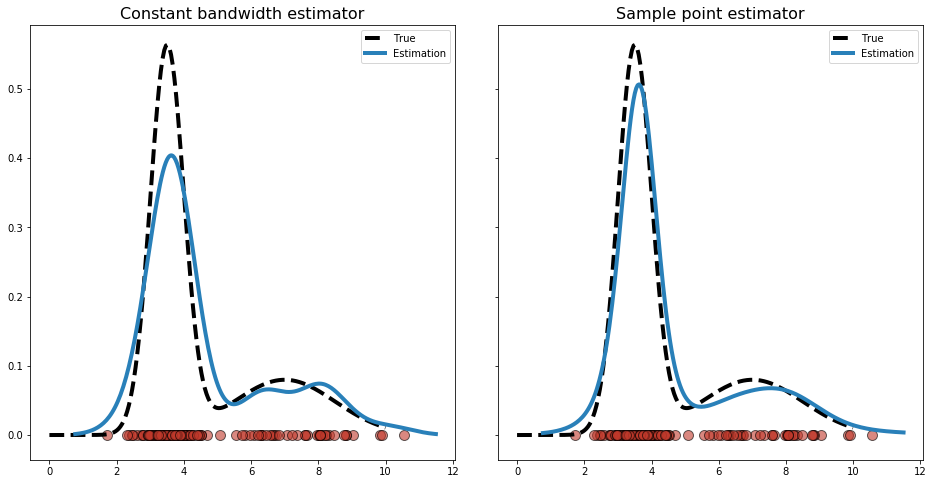

In [7]:
np.random.seed(1234)
x_grid = np.linspace(0, 10, 200)
mean = [3.5, 7]
sd = [0.5, 1.5]
wt = [0.70, 0.30]
n = 150

rvs = generate_rvs(n, mean, sd, wt)
pdf_true = get_pdf(x_grid, mean, sd, wt)

x1, y1 = convolution_kde(rvs)
x2, y2, h = gaussian_kde_adap(rvs)

plot_custom_kde(x_grid, pdf_true, x1, y1, x2, y2)

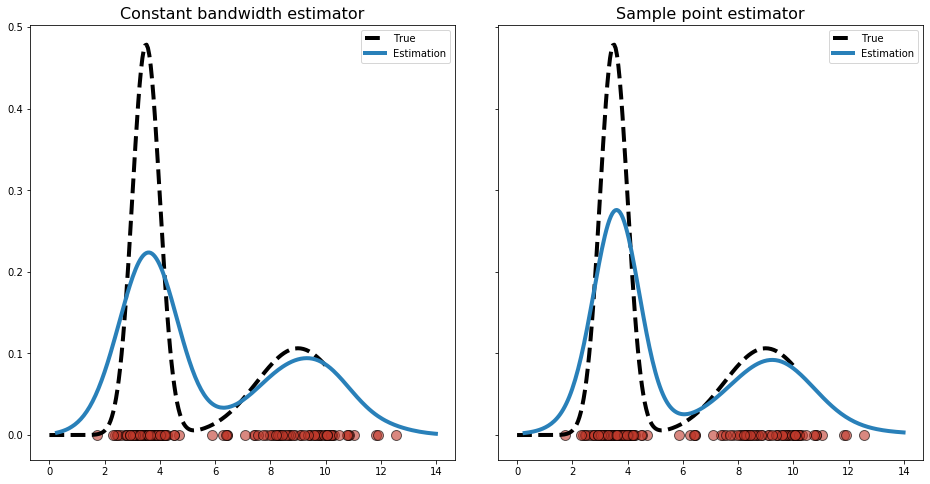

In [8]:
np.random.seed(1234)
x_grid = np.linspace(0, 10, 200)
mean = [3.5, 9]
sd = [0.5, 1.5]
wt = [0.6, 0.4]
n = 150

rvs = generate_rvs(n, mean, sd, wt)
pdf_true = get_pdf(x_grid, mean, sd, wt)

x1, y1 = convolution_kde(rvs)
x2, y2, h = gaussian_kde_adap(rvs)

plot_custom_kde(x_grid, pdf_true, x1, y1, x2, y2)

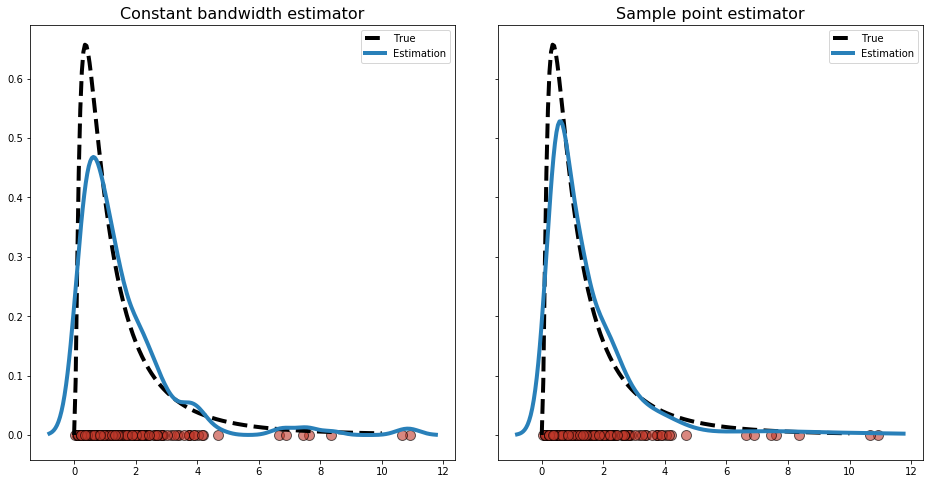

In [9]:
np.random.seed(1234)
x_grid = np.linspace(0, 10, 200)
mean = [3.5, 9]
sd = [0.5, 1.5]
wt = [0.6, 0.4]
n = 200

rvs = stats.lognorm.rvs(s=1, size=n)
pdf_true = stats.lognorm.pdf(x_grid, s=1)

x1, y1 = convolution_kde(rvs)
x2, y2, h = gaussian_kde_adap(rvs)

plot_custom_kde(x_grid, pdf_true, x1, y1, x2, y2)

It can be easily seen that the classical KDEcontains a few spurious bums (left plot).

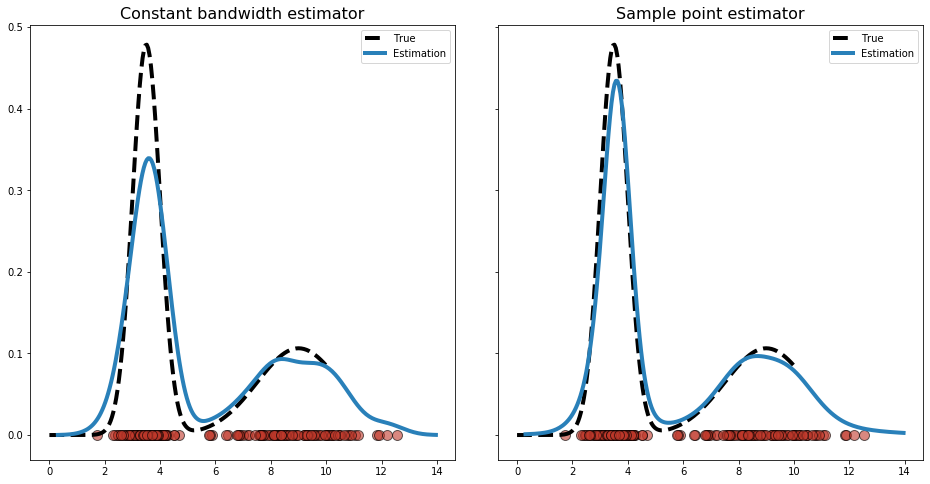

In [10]:
# This alternative goes in an appendix because it is not our topic yet.
np.random.seed(1234)
x_grid = np.linspace(0, 10, 200)
mean = [3.5, 9]
sd = [0.5, 1.5]
wt = [0.6, 0.4]
n = 200

rvs = generate_rvs(n, mean, sd, wt)
pdf_true = get_pdf(x_grid, mean, sd, wt)

hisj = h_isj(rvs)
hsil = h_sil(rvs)

h = (hisj + hsil) / 2
# h = hisj
     
x1, y1 = convolution_kde(rvs, h=h)
x2, y2, h = gaussian_kde_adap(rvs, h=h)

plot_custom_kde(x_grid, pdf_true, x1, y1, x2, y2)